# 올리브영 크롤링

In [5]:
# 라이브러리 불러오기
from selenium import webdriver # 브라우저 자동화를 위한 모듈
import requests # HTTP 요청을 보내기 위한 모듈
from bs4 import BeautifulSoup as bs # HTML 내용 파싱을 위한 모듈
import pandas as pd # 데이터 조작 및 분석을 모듈
import time # 코드 실행 속도 조절을 위한 모듈
import re # 정규 표현식 사용을 위한 모듈
import pickle # 파이썬 객체 직렬화를 위한 모듈
from selenium.webdriver.common.by import By # 다양한 방법으로 엘리먼트를 찾기 위한 모듈
import datetime # 날짜와 시간 연산을 위한 모듈

# 올리브영 모든 제품 링크 추출해오기

In [153]:
# 드라이버 불러오기
driver = webdriver.Chrome()
driver.get('https://www.oliveyoung.co.kr/store/display/getMCategoryList.do?dispCatNo=100000100010015&isLoginCnt=0&aShowCnt=0&bShowCnt=0&cShowCnt=0&gateCd=Drawer&trackingCd=Cat100000100010015_MID&trackingCd=Cat100000100010015_MID&t_page=드로우_카테고리&t_click=카테고리탭_중카테고리&t_2nd_category_type=중_크림')

In [ ]:
link = []  # 링크를 저장할 리스트 생성

# 1부터 26까지 반복
for i in range(1, 27):
    # 해당 페이지의 URL 생성
    url = 'https://www.oliveyoung.co.kr/store/display/getMCategoryList.do?dispCatNo=100000100010015&fltDispCatNo=&prdSort=01&pageIdx=' + str(i) + '&rowsPerPage=24&searchTypeSort=btn_thumb&plusButtonFlag=N&isLoginCnt=0&aShowCnt=&bShowCnt=&cShowCnt=&trackingCd=Cat100000100010015_Small&amplitudePageGubun=&t_page=&t_click=&midCategory=%ED%81%AC%EB%A6%BC&smallCategory=%EC%A0%84%EC%B2%B4&checkBrnds=&lastChkBrnd='
    
    # 현재 탭을 첫 번째로 전환
    driver.switch_to.window(driver.window_handles[0])
    # URL을 실행하여 새 탭 열기
    driver.execute_script("window.open('{}')".format(url))
    # 새로 열린 탭으로 전환
    driver.switch_to.window(driver.window_handles[1])
    # 페이지가 로딩될 때까지 잠시 대기
    time.sleep(2)
    # 현재 페이지의 HTML 코드 가져오기
    html = driver.page_source
    # BeautifulSoup을 사용하여 HTML 파싱
    soup = BS(html, 'html.parser')
    # 상품 정보가 있는 요소들을 찾기
    items = soup.find_all("div", attrs={"class": "prd_info"})
    
    # 각 상품 정보에서 링크를 찾아 link 리스트에 추가
    for item in items:
        link.append(item.find("a", attrs={"class": "prd_thumb goodsList"}).attrs['href'])
    
    # 탭 닫기
    driver.close()
    # 다음 페이지 크롤링 전에 잠시 대기
    time.sleep(0.3)

In [ ]:
# 데이터 저장하기
raw_data = pd.DataFrame()
raw_data['link'] = link
raw_data.to_csv("oliveyoung_all_link.csv")

# 리뷰가 2000개 이상인 제품 링크 추출해서 샘플 링크로 저장

In [ ]:
# 데이터 불러오기
raw_data=pd.read_csv("oliveyoung_all_link.csv")
driver = webdriver.Chrome()
driver.get('https://www.oliveyoung.co.kr/store/display/getMCategoryList.do?dispCatNo=100000100010015&isLoginCnt=0&aShowCnt=0&bShowCnt=0&cShowCnt=0&gateCd=Drawer&trackingCd=Cat100000100010015_MID&trackingCd=Cat100000100010015_MID&t_page=드로우_카테고리&t_click=카테고리탭_중카테고리&t_2nd_category_type=중_크림')

In [ ]:
from selenium.common.exceptions import TimeoutException
review=[]

for i in range(len(raw_data)):
    url = raw_data['link'][i]
    try:
        driver.switch_to.window(driver.window_handles[0]) # 첫 번째 탭으로 이동
        driver.execute_script("window.open('{}')".format(url)) # URL 실행
        driver.switch_to.window(driver.window_handles[1]) # 두 번째 탭으로 이동
        time.sleep(0.5)
        html = driver.page_source  # 현재 페이지의 HTML 코드를 가져옴
        soup = BS(html, 'html.parser')
        review_count = soup.find("a", attrs={"class": "goods_reputation"})
        num=int(re.sub(r'[^0-9]', '', review_count.find("span").text))
        if (num>=2000):
            link.append(url)
            review.append(num)
    except TimeoutException as e:
        println(url)
    finally:
        driver.close()
        time.sleep(0.3)
        if(i%10==0):
            print(str(i)+"/"+str(len(raw_data)))

In [ ]:
# 데이터 저장하기
raw_data = pd.DataFrame()
raw_data['link'] = link
raw_data.to_csv("oliveyoung_sample_link.csv")

# 전체 제품 이름, 가격, 별점, 리뷰 가져오기

In [2]:
# url로 연결하여 크롤링되게 하기
url_df = pd.read_csv('oliveyoung_all_link.csv')
urls =url_df['link'].tolist()

In [ ]:
# 크롬 드라이버 로드
driver = webdriver.Chrome()

# 각 리스트 초기화
title = []  # 제품 이름 리스트
price = [] # 제품 가격 리스트
star = [] # 총 별점 리스트 
review_cnt = [] # 리뷰 총 개수 리스트


for url in urls:
    # 웹 페이지 열기
    driver.get(url)

    # 페이지가 완전히 로드될 때까지 대기
    time.sleep(2)  # 2초 대기. 필요한 경우 조정

    # 페이지 소스를 가져와서 BeautifulSoup으로 파싱
    soup = bs(driver.page_source, 'html.parser')

    # 제목
    try:
        a = soup.find('p', class_='prd_name').get_text(strip=True)
    except:
        a = 'null'
    title.append(a)
    
    # 가격
    try:
        b = soup.find('span', class_='price-2').get_text(strip=True)
    except:
        b = 'null'
    price.append(b)
    
    # 리뷰 총 개수
    try:
        c = soup.find('em').get_text(strip=True)
    except:
        c = 'null'
    review_cnt.append(c)
    

# 드라이버 종료
driver.quit()

# 크롤링한 데이터를 데이터프레임으로 변환
raw_data = pd.DataFrame({
    'title' : title,
    'price' : price,
    'review_cnt' : review_cnt
})

# csv로 저장
raw_data.to_csv('oliveyoung.csv', index=False, encoding="utf-8-sig")

# 결과 출력
print(raw_data)

# 전처리

In [4]:
data = pd.read_csv('oliveyoung.csv')

In [5]:
# 댓글 개수의 숫자화
for i in range(len(data)):

    # price에서 숫자를 제외한 모든 문자를 삭제
    data['price'][i] = re.sub("[^0-9]", "", str(data['price'][i]))
    
    # review_cnt에서 숫자를 제외한 모든 문자를 삭제
    data['review_cnt'][i] = re.sub("[^0-9]", "", str(data['review_cnt'][i]))
    
data

/var/folders/01/3d4wx8r11dx2kjml_tq2t48c0000gn/T/ipykernel_61116/2893240196.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'][i] = re.sub("[^0-9]", "", str(data['price'][i]))
/var/folders/01/3d4wx8r11dx2kjml_tq2t48c0000gn/T/ipykernel_61116/2893240196.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '29700' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data['price'][i] = re.sub("[^0-9]", "", str(data['price'][i]))
/var/folders/01/3d4wx8r11dx2kjml_tq2t48c0000gn/T/ipykernel_61116/2893240196.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

,title,price,review_cnt
0,에스트라 아토베리어365 크림 80ml 기획 (+하이드로에센스 25ml+리제덤세럼 ...,29700,5467
1,라로슈포제 시카플라스트 크림 B5 100ml 기획 (시카토너50ml+시카밤3ml*2),39200,1590
2,[쿨링진정] 아비브 어성초 크림 카밍 튜브 75ml 1+1 한정기획,26200,939
3,[2세대 천만크림] 닥터지 레드 블레미쉬 클리어 수딩 크림 70ml+30ml 세트,28800,21356
4,라로슈포제 시카플라스트 밤B5+ 100ml 기획 (+시카크림 15ml 증정),31200,3400
...,...,...,...
590,[가벼운 여름용] 피지오겔 DMT 하이드로 젤 수분크림 70ml+30ml 기획,23500,634
591,수려한 비책 진생 크림 기획 (크림 30ml + 수액 25ml + 유액 25ml),36000,17
592,숨37 워터풀 마린 릴리프 젤 크림 50ml,68000,39
593,[한정수량]닥터디퍼런트 비타리프트 에이 더블 기획,56700,920


In [6]:
# 데이터 int가 아닌 object임을 확인
data.info()

# 데이터 타입 변경
# 데이터를 데이터프레임으로 변환
df= pd.DataFrame(data)

# 'price' 열에서 빈 문자열을 NaN으로 변환
df['price'] = df['price'].replace('', pd.NA)
df['review_cnt'] = df['review_cnt'].replace('', pd.NA)

# NaN 값을 적절한 값으로 대체하고 정수형으로 변환
df['price'] = df['price'].fillna(0).astype(int)
df['review_cnt'] = df['review_cnt'].fillna(0).astype(int)

df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price_range             14 non-null     object 
 1   total_reviews           14 non-null     int64  
 2   product_count           14 non-null     int64  
 3   purchase_rate           14 non-null     float64
 4   additional_score        14 non-null     float64
 5   adjusted_purchase_rate  14 non-null     float64
dtypes: float64(3), int64(2), object(1)
memory usage: 800.0+ bytes


KeyError: 'price'

In [7]:
# 데이터 확인 작업
# 리뷰수가 2000개 이상인 데이터
df_filtered = df[df["review_cnt"] >= 2000]
print(df_filtered.max())

# 리뷰 수가 가장 많은 행 찾기
max_row = df[df["review_cnt"] == df["review_cnt"].max()]
print(max_row)

# 사용할 데이터
real_data = df[(df.price <= 78000) & (df.price >= 10000)].reset_index(drop=True)


title         한율 어린쑥 수분진정 크림 110ml 대용량 기획 (+25ml+ 패드2매+흡착팩폼2ml)
price                                                     78000
review_cnt                                                42061
dtype: object
                                                 title  price  review_cnt
459  에스트라 아토베리어365 크림 80ml 기획 (+하이드로에센스 25ml+무기자차선크...  31000       42061


# 가격과 상품 개수 바그래프 제작

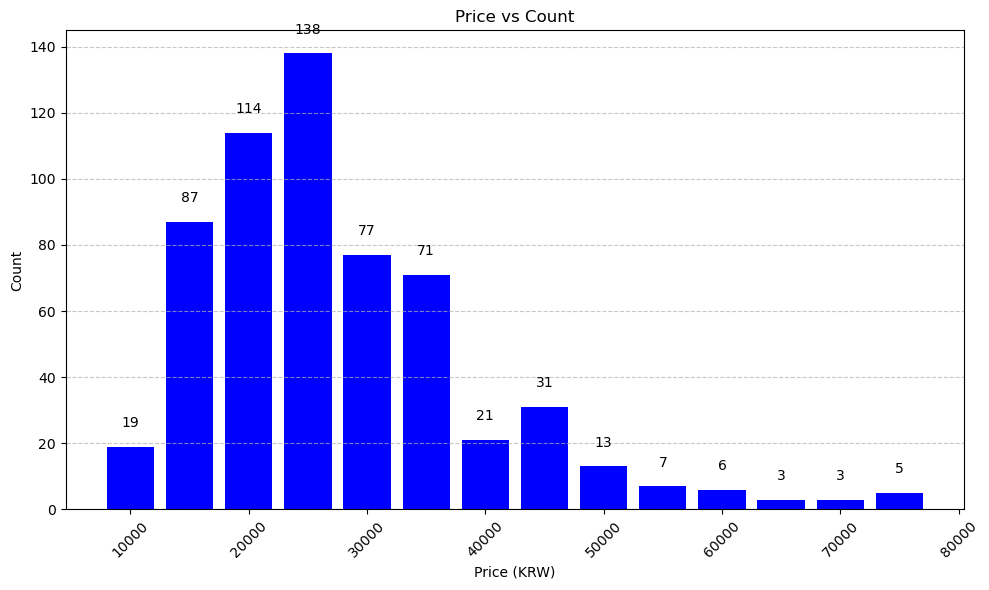

In [8]:
import matplotlib.pyplot as plt

# 가격을 5000원 단위로 나누어 가격 범위 생성
price_ranges = range((real_data['price'].min() // 5000) * 5000, ((real_data['price'].max() + 5000) // 5000) * 5000, 5000)

# 각 가격 범위에 대한 제품 개수 계산
review_counts = []
for price_range in price_ranges:
    filtered_data = real_data[(real_data['price'] >= price_range) & (real_data['price'] < price_range + 5000)]
    review_counts.append(filtered_data['review_cnt'].count())

# 바 그래프 그리기
plt.figure(figsize=(10, 6))
bars = plt.bar(price_ranges, review_counts, color='blue', width=4000)  # 가격 범위 별로 바 그래프 그리기
plt.title('Price vs Count')
plt.xlabel('Price (KRW)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 바 위에 값을 표시
for bar, num in zip(bars, review_counts):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 5, str(num), 
             ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()


# 가격과 리뷰 개수 시각화

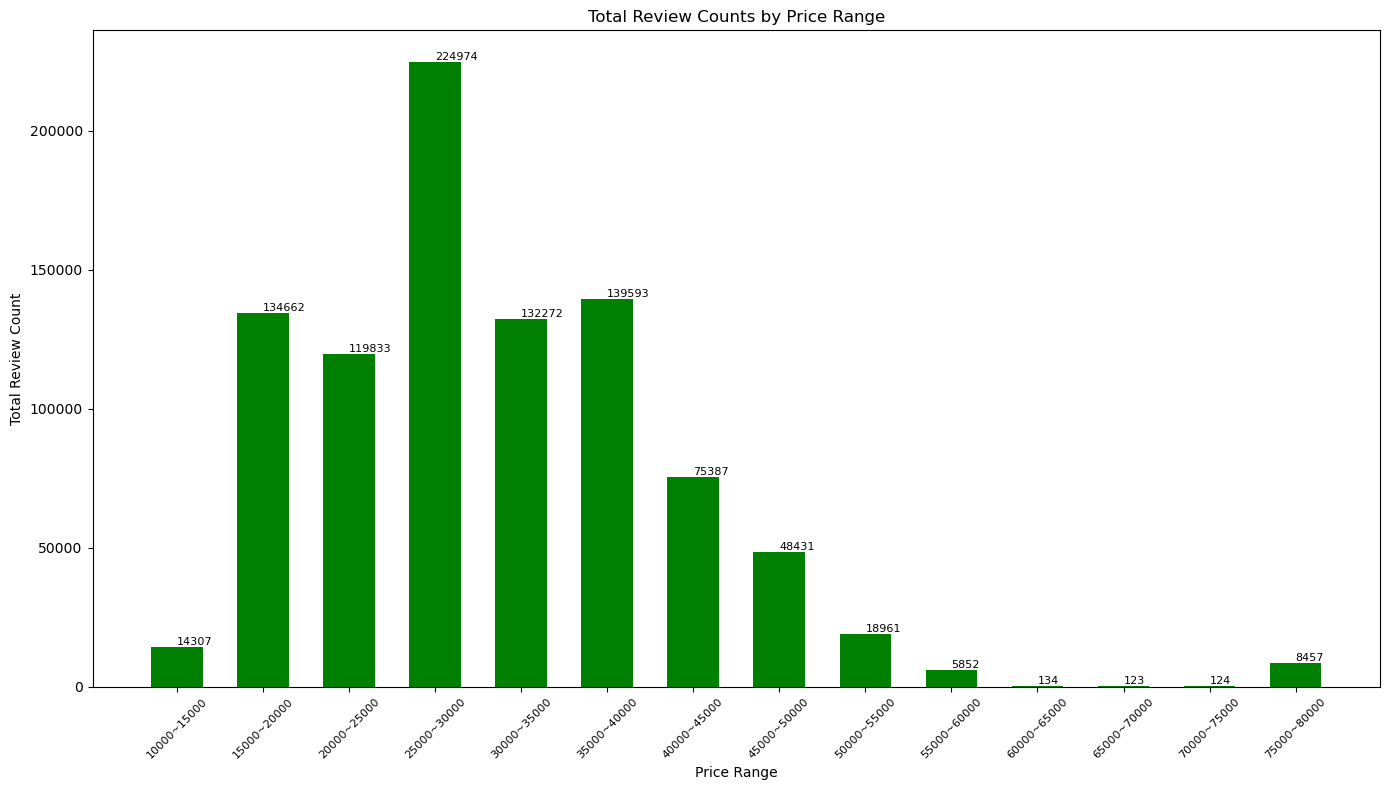

In [9]:
# 총리뷰 개수와 5000원단위의 상품의 그래프

# 5000원 단위 범위 설정
price_ranges = [(10000, 15000), (15000, 20000), (20000, 25000), (25000, 30000),
                (30000, 35000), (35000, 40000), (40000, 45000), (45000, 50000),
                (50000, 55000), (55000, 60000), (60000, 65000), (65000, 70000),
                (70000, 75000), (75000, 80000)]

# 각 가격 범위에 대한 review_cnt_total 계산
review_cnt_totals = []
price_range_labels = []

for start_price, end_price in price_ranges:
    # 데이터 필터링
    data = real_data[(real_data.price < end_price) & (real_data.price >= start_price)]
    
    # review_cnt_total 계산
    review_cnt_total = data['review_cnt'].sum()
    review_cnt_totals.append(review_cnt_total)
    price_range_labels.append(f'{start_price}~{end_price}')

# 바 그래프 그리기
plt.figure(figsize=(14, 8))
bars = plt.bar(price_range_labels, review_cnt_totals, color='green', width=0.6)

# 바 그래프 위에 값 작성
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), va='bottom', fontsize=8)

plt.title('Total Review Counts by Price Range')
plt.xlabel('Price Range')
plt.ylabel('Total Review Count')

plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()

# 샘플 링크에서 별점, 리뷰 내용, 피부 타입 추출

In [ ]:
link = pd.read_csv('oliveyoung_sample_link.csv')
link=link['link']
driver = webdriver.Chrome()
driver.get('https://www.oliveyoung.co.kr/store/display/getMCategoryList.do?dispCatNo=100000100010015&isLoginCnt=0&aShowCnt=0&bShowCnt=0&cShowCnt=0&gateCd=Drawer&trackingCd=Cat100000100010015_MID&trackingCd=Cat100000100010015_MID&t_page=드로우_카테고리&t_click=카테고리탭_중카테고리&t_2nd_category_type=중_크림')

In [ ]:
# 페이지에서 데이터 읽어오는 함수
def info_get(index):
    # 현재 페이지의 HTML 코드를 가져옴
    html = driver.page_source  
    # BeautifulSoup을 사용하여 HTML 파싱
    soup = BS(html, 'html.parser')
                    
    # 사용자 정보를 포함한 div 요소를 찾기
    info = soup.find_all("div", attrs={"class":"user clrfix"})
    for i in range(len(info)):
        # 피부 타입 정보 추출
        try:
            sk = info[i].find("p", attrs={"class":'tag'})
            type = ""
            for k in sk.find_all("span"):
                type += k.text + ","
            
            # 마지막 쉼표 제거
            type = type[:-1]
            # 해당 인덱스에 피부 타입 정보 추가
            skin_type[index].append(type)
        except:
            # 정보가 없을 경우 빈 문자열 추가
            skin_type[index].append("")

    # 리뷰 내용을 포함한 div 요소를 찾기
    review = soup.find_all("div", attrs={"class":"review_cont"})
    for i in range(len(review)):
        # 리뷰 내용 추출
        try:
            re = review[i].find("div", attrs={"class": "txt_inner"}).text
            # 해당 인덱스에 리뷰 내용 추가
            reviews[index].append(re)
        except:
            # 정보가 없을 경우 빈 문자열 추가
            reviews[index].append("")
        
        # 별점 추출
        try:
            st = review[i].find("span", attrs={"class":"point"}).text
            st = st.split("5점만점에 ", 1)[1]
            # 해당 인덱스에 별점 정보 추가
            star[index].append(st)
        except:
            # 정보가 없을 경우 빈 문자열 추가
            star[index].append("")


In [ ]:
for index in check_index:
    page_num = 1  # 페이지 번호 초기화
    url = link[index]
    try:
        driver.switch_to.window(driver.window_handles[0])  # 첫 번째 탭으로 이동
        driver.execute_script("window.open('{}')".format(url))  # URL 실행
        driver.switch_to.window(driver.window_handles[1])  # 두 번째 탭으로 이동
        time.sleep(1)  # 페이지 로딩 대기
        driver.execute_script("window.scrollTo(0, 1500)")  # 페이지 스크롤 다운
        driver.find_element(By.ID, 'reviewInfo').click()  # 리뷰 탭 클릭
        time.sleep(1)
        driver.find_element(By.ID, 'searchType_1').click()  # 리뷰 필터 클릭
        driver.find_element(By.ID, 'searchType_3').click()  # 리뷰 필터 클릭
        driver.find_element(By.XPATH, '//*[@id="gdasSort"]/li[3]/a').click()  # 리뷰 정렬 기준 클릭
        time.sleep(1)
        driver.execute_script("window.scrollTo(0, 2500)")  # 페이지 스크롤 다운
        time.sleep(1)
        
        while True:
            try:
                time.sleep(1)
                driver.execute_script("window.scrollTo(0, 4000)")  # 페이지 스크롤 다운
                time.sleep(1.5)
                err = 0
                for i in range(10):
                    if page_num == 100:  # 페이지 수가 100이면 종료
                        info_get(index)
                        break
                    if page_num > 10:
                        i += 1
                    page_num += 1
                    try:
                        info_get(index)  # 리뷰 정보 추출 함수 호출
                        driver.execute_script("window.scrollTo(0, 4000)")  # 페이지 스크롤 다운
                        time.sleep(1)
                        page = driver.find_element(By.CLASS_NAME, 'pageing')  # 페이지 네비게이션 요소 찾기
                        page = page.find_elements(By.TAG_NAME, 'a')
                        time.sleep(1)
                        page[i].click()  # 다음 페이지 클릭
                        time.sleep(1)
                    except Exception as e:
                        print(e)  # 예외 발생 시 출력
                        err = 1
                        break
                if page_num == 100:  # 페이지 수가 100이면 종료
                    break
                if err == 1:  # 예외 발생 시 루프 종료
                    break
            except Exception as e:
                print(e)  # 예외 발생 시 출력
                break
    except Exception as e:
        print("페이지 이상: link " + str(index))  # 예외 발생 시 출력
    finally:
        driver.close()  # 탭 닫기
        time.sleep(0.3)  # 대기
        if index 


In [ ]:
# 제대로 못 가져온 것들 아예 None 처리하고 위 코드 반복해서 다 가져오기

check_index=[]

for i in range(len(star)):
    if i!=106:
        if len(skin_type[i])==len(star[i])==len(reviews[i])==1000:
            continue
        else:
            skin_type[i]=[]#None
            star[i]=[]#None
            reviews[i]=[]#None
            check_index.append(i)

In [ ]:
#올리브영이 제품을 내려서 없는 페이지들 None 처리
for i in check_index:
    star[i]=None
    reviews[i]=None
    skin_type[i]=None

In [ ]:
# 데이터프레임으로 제작하고 저장하기
data = pd.DataFrame()
data['star'] = star
data['review'] = reviews
data['skin_type'] = skin_type

data.to_csv("oliveyoung_sample_review.csv")

# 리뷰 감성분석

In [70]:
a= pd.read_csv("oliveyoung_cut_review.csv")

In [72]:
# 제목, 본문, 댓글의 한글화
# 댓글 개수의 숫자화
for i in range(len(a)):
    # review에서 영문 대소문자, 한글, 숫자, 공백 문자를 제외한 모든 문자를 삭제
    a['review'][i] = re.sub("[^0-9a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣 ]", '', str(a['review'][i]))
    
    # star에서 숫자를 제외한 모든 문자를 삭제
    a['star'][i] = re.sub("[^0-9]", "", str(a['star'][i]))
    
    

In [73]:
# 'star' 열에서 빈 문자열을 NaN으로 변환
a['star'] = a['star'].replace('', int(0))

# NaN 값을 적절한 값으로 대체하고 정수형으로 변환
# a['star'] = a['star'].fillna(0).astype(int)

In [74]:
data=a

In [75]:
# 데이터프레임에 감성분석 score 삽입
import json
from tqdm import tqdm

# 감정분석 json데이터(knu감성사전) 불러오기
with open('SentiWord_info.json',encoding = 'UTF-8') as json_file:
    sentiword = json.load(json_file)

s_word = []  
values = []
score = []

def average(list):  # 각 문서의 평균 감성 score 반환  # 리스트의 평균 값을 계산하는 함수
    return sum(list)/len(list)

for word in tqdm(data['review']):
    temp_s_word=[]    # 문서에서 발견된 감성 단어 리스트 초기화
    temp_value=[]
    
# 감성사전에 있는 단어와 현재 문서의 단어 비교
    for s in sentiword:
        if s['word'] in word:
            if len(s['word']) > 1 : # 한글자 이상의 감성단어와 비교 
                temp_s_word.append(s['word'])
                temp_value.append(int(s['polarity'])) 
    s_word.append(temp_s_word) # 해당하는 감성단어 추가
    values.append(temp_value) # 해당 단어의 polarity값 추가
    try:
        score.append(average(temp_value)) # 각 문서의 평균 polarity 추가
    except ZeroDivisionError:
        score.append(int(0))

# 결과 데이터프레임에 감성분석 결과 삽입
data=data.assign(sentiword = s_word,values=values,score=score) # 결과 데이터프레임에 삽입

100%|██████████████████████████████████| 109240/109240 [02:16<00:00, 797.46it/s]


In [115]:
total_docs = pd.DataFrame()
# total_docs['title'] = data['title']
total_docs['star'] = data['star']
total_docs['review'] = data['review']
total_docs['sentiword'] = data['sentiword']
total_docs['values'] = data['values']
total_docs['score'] = data['score']


KeyError: 'star'

# 샘플 링크에서 리뷰 갯수 가져오기

In [46]:
link=pd.read_csv("oliveyoung_sample_link.csv")
review_cnt = []  # 리뷰 수를 저장할 리스트 생성

for index in range(len(link)):
    url = link[index]  # 각 링크를 순회하며 URL을 가져옴
    try:
        driver.switch_to.window(driver.window_handles[0])  # 첫 번째 탭으로 이동
        driver.execute_script("window.open('{}')".format(url))  # URL을 실행하여 새 탭 열기
        driver.switch_to.window(driver.window_handles[1])  # 새로 열린 두 번째 탭으로 이동
        time.sleep(0.5)  # 페이지 로딩 대기
        html = driver.page_source  # 현재 페이지의 HTML 코드를 가져옴
        soup = BS(html, 'html.parser')  # BeautifulSoup을 사용하여 HTML 파싱
        review_count = soup.find("a", attrs={"class": "goods_reputation"})  # 리뷰 수가 포함된 요소를 찾기
        num = int(re.sub(r'[^0-9]', '', review_count.find("span").text))  # 리뷰 수를 정수로 변환
        review_cnt.append(num)  # 리뷰 수를 리스트에 추가
    except Exception as e:
        print("페이지 이상: link " + str(index))  # 예외 발생 시 출력
    finally:
        driver.close()  # 탭 닫기
        time.sleep(0.3)  # 대기
        if index % 10 == 0:  # 10번째마다 진행 상황 출력
            print(str(index) + "/" + str(len(link)))

NameError: name 'link' is not defined

In [ ]:
# 내린 제품들 None 처리
review_cnt.insert(19, None)  # 인덱스 19에 None 값을 삽입
review_cnt.insert(76, None)  # 인덱스 76에 None 값을 삽입

raw_data = pd.DataFrame()  # 빈 데이터프레임 생성
raw_data['review_cnt'] = review_cnt  # 'review_cnt' 컬럼에 리뷰 수 리스트 할당

raw_data.to_csv("oliveyoung_sample_review_cnt.csv")  # 데이터를 CSV 파일로 저장

# 샘플 링크 광고 사진 텍스트 추출

In [ ]:
raw_data=pd.read_csv("oliveyoung_sample_link.csv")
driver = webdriver.Chrome()
driver.get('https://www.oliveyoung.co.kr/store/display/getMCategoryList.do?dispCatNo=100000100010015&isLoginCnt=0&aShowCnt=0&bShowCnt=0&cShowCnt=0&gateCd=Drawer&trackingCd=Cat100000100010015_MID&trackingCd=Cat100000100010015_MID&t_page=드로우_카테고리&t_click=카테고리탭_중카테고리&t_2nd_category_type=중_크림')

In [ ]:
img_link = [[] for i in range(len(link))]  # 링크 리스트의 길이만큼 빈 리스트를 생성

for i in range(len(link)):
    url = link[i]  # 각 링크를 순회하며 URL을 가져옴
    try:
        driver.switch_to.window(driver.window_handles[0])  # 첫 번째 탭으로 이동
        driver.execute_script("window.open('{}')".format(url))  # URL 실행하여 새 탭 열기
        driver.switch_to.window(driver.window_handles[1])  # 새로 열린 두 번째 탭으로 이동
        time.sleep(0.5)  # 페이지 로딩 대기
        html = driver.page_source  # 현재 페이지의 HTML 코드를 가져옴
        soup = BS(html, 'html.parser')  # BeautifulSoup을 사용하여 HTML 파싱
        driver.close()  # 현재 탭 닫기
        
        group = soup.find("div", attrs={"class": "iPrdViewimg"})  # 이미지 그룹 찾기
        if group is None:
            group = soup.find_all("picture")  # 이미지 그룹이 없으면 picture 요소 찾기
        img = []
        for j in group:
            if isinstance(j, NavigableString):
                continue  # NavigableString인 경우 건너뜀
            img.append(j.find_all("img"))  # 이미지 요소들을 리스트에 추가
        for j in img:
            for m in j:
                if m["src"][0:8] != "https://":
                    img_link[i].append(m["data-src"])  # src 속성이 https://로 시작하지 않으면 data-src 속성 사용
                else:
                    img_link[i].append(m["src"])  # src 속성이 https://로 시작하면 src 속성 사용
    except Exception:
        print(url)  # 예외 발생 시 URL 출력
    finally:
        time.sleep(0.3)  # 대기
        if i % 10 == 0:  # 10번째마다 진행 상황 출력
            print(str(i) + "/" + str(len(link)))

In [ ]:
raw_data = pd.DataFrame()
raw_data['img_link'] = img_link
raw_data.to_csv("oliveyoung_img_link.csv")

# 올리브영 상세설명 이미지 텍스트 추출

In [1]:
!pip install google-cloud-vision pandas requests
!pip install google-cloud-vision pandas

In [3]:
# 라이브러리 불러오기
import requests  # HTTP 요청을 보내기 위한 모듈
import re  # 정규 표현식 사용을 위한 모듈
import pickle  # 파이썬 객체 직렬화를 위한 모듈
from selenium.webdriver.common.by import By  # 다양한 방법으로 엘리먼트를 찾기 위한 모듈
import datetime  # 날짜와 시간 연산을 위한 모듈
import pandas as pd  # 데이터 분석 및 조작을 위한 모듈
from PIL import Image  # 이미지 처리 모듈
from io import BytesIO  # 바이트 데이터를 I/O 스트림으로 변환하는 모듈
from google.cloud import vision  # 구글 클라우드 비전 API를 사용하기 위한 모듈
from google.cloud.vision_v1 import types  # 구글 클라우드 비전 API의 types 모듈
import os  # 운영체제 기능을 위한 모듈
from selenium import webdriver  # 웹 브라우저 자동화를 위한 모듈
from bs4 import BeautifulSoup  # HTML 및 XML 파싱을 위한 모듈
import time  # 시간 관련 기능을 위한 모듈

In [ ]:
# Set up Google Cloud Vision client
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "C:\\Users\\pyk71\\Downloads\\pure-pact-424808-h2-a23064dcc19d.json"
client = vision.ImageAnnotatorClient()

# CSV 파일 읽기
img_df = pd.read_csv('oliveyoung_img_link.csv')
sample_link_df = pd.read_csv('oliveyoung_sample_link.csv')

# 크롬 드라이버 설정
driver = webdriver.Chrome()

# 이미지 링크 열 이름 수정 ('img_link'로 가정)
image_links = img_df['img_link'].tolist()

# URL 확인 및 정리 - 리스트 요소를 문자열로 변환
image_links = [url.strip("[]'\" ") for url in image_links if isinstance(url, str)]

# 각 링크에서 제품명 추출
product_titles = []
for i, url in enumerate(sample_link_df['link'].tolist()):
    try:
        driver.get(url)
        time.sleep(2)  # 페이지 로딩 대기

        # 페이지 소스를 가져와서 BeautifulSoup으로 파싱
        soup = BeautifulSoup(driver.page_source, 'html.parser')

        # 제품명 추출
        product_title_tag = soup.find('p', class_='prd_name')
        if product_title_tag:
            product_title = product_title_tag.get_text(strip=True)
        else:
            product_title = 'null'

        # 제품명 저장
        product_titles.append(product_title)

    except Exception as e:
        print(f"Error processing {url}: {e}")
        product_titles.append('null')

    finally:
        if i % 10 == 0:
            print(f"Processed {i + 1}/{len(sample_link_df)} links")

# 드라이버 종료
driver.quit()

# 이미지 다운로드 함수
def download_image(url):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            return response.content
        else:
            return None
    except Exception as e:
        print(f"Error downloading {url}: {e}")
        return None

# 이미지에서 텍스트 추출 함수 (Google Cloud Vision API 사용)
def extract_text_from_image(image_content):
    if image_content is not None:
        image = types.Image(content=image_content)
        response = client.text_detection(image=image)
        texts = response.text_annotations
        if texts:
            return texts[0].description
        else:
            return ''
    else:
        return 'NAN'

# 이미지 리스트 생성 및 텍스트 추출
texts = []
for i, url in enumerate(image_links):
    image_content = download_image(url)
    text = extract_text_from_image(image_content)
    texts.append(text)

# 크롤링한 데이터를 데이터프레임으로 변환
raw_data = pd.DataFrame({
    'Product Title': product_titles,
    'Extracted Text': texts
})

# 추출한 제품명과 텍스트를 새로운 CSV 파일로 저장
result_df = pd.DataFrame({'Product Title': product_titles, 'Extracted Text': texts})
result_df.to_csv('extracted_texts_and_titles.csv', index=False, encoding='utf-8')

print("텍스트 추출 및 저장 완료")

In [ ]:
result_df = pd.read_csv('extracted_texts_and_titles.csv')
result_df

## 추출 실패한 항목

In [ ]:
import pandas as pd
import requests
from google.cloud import vision
from google.cloud.vision_v1 import types
from selenium import webdriver
from bs4 import BeautifulSoup
import time
import os

# Set up Google Cloud Vision client
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "C:\\Users\\pyk71\\Downloads\\pure-pact-424808-h2-a23064dcc19d.json"
client = vision.ImageAnnotatorClient()

# CSV 파일 읽기
img_df = pd.read_csv('oliveyoung_img_link.csv')
sample_link_df = pd.read_csv('oliveyoung_sample_link.csv')

# 크롬 드라이버 설정
driver = webdriver.Chrome()

# 이미지 링크 열 이름 수정 ('img_link'로 가정)
image_links = img_df['img_link'].tolist()

# URL 확인 및 정리 - 리스트 요소를 문자열로 변환
image_links = [url.strip("[]'\" ") for url in image_links if isinstance(url, str)]

# 각 링크에서 제품명 추출
product_titles = []
for i, url in enumerate(sample_link_df['link'].tolist()):
    try:
        driver.get(url)
        time.sleep(1)  # 페이지 로딩 대기

        # 페이지 소스를 가져와서 BeautifulSoup으로 파싱
        soup = BeautifulSoup(driver.page_source, 'html.parser')

        # 제품명 추출
        product_title_tag = soup.find('p', class_='prd_name')
        if product_title_tag:
            product_title = product_title_tag.get_text(strip=True)
        else:
            product_title = 'null'

        # 제품명 저장
        product_titles.append(product_title)

    except Exception as e:
        print(f"Error processing {url}: {e}")
        product_titles.append('null')

    finally:
        if i % 10 == 0:
            print(f"Processed {i + 1}/{len(sample_link_df)} links")

# 드라이버 종료
driver.quit()

# 이미지 다운로드 함수
def download_image(url):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            return response.content
        else:
            return None
    except Exception as e:
        print(f"Error downloading {url}: {e}")
        return None

# 이미지에서 텍스트 추출 함수 (Google Cloud Vision API 사용)
def extract_text_from_image(image_content):
    if image_content is not None:
        image = types.Image(content=image_content)
        response = client.text_detection(image=image)
        texts = response.text_annotations
        if texts:
            return texts[0].description
        else:
            return ''
    else:
        return ''

# 이미지 리스트 생성 및 텍스트 추출
texts = []
failed_indices = []  # 텍스트 추출이 실패한 이미지의 인덱스를 저장할 리스트

for i, url in enumerate(image_links):
    image_content = download_image(url)
    text = extract_text_from_image(image_content)
    texts.append(text)
    if not text:
        failed_indices.append(i)  # 텍스트 추출이 실패한 경우 인덱스를 저장


# 텍스트 추출이 실패한 항목을 따로 저장
failed_df = result_df.iloc[failed_indices]
failed_df.to_csv('failed_text_extraction.csv', index=False, encoding='utf-8')

print("텍스트 추출 및 저장 완료")

In [ ]:
failed = pd.read_csv('failed_text_extraction.csv')
failed

In [ ]:
# 추출된 텍스트와 제품명을 포함한 CSV 파일 읽기
result_df = pd.read_csv('extracted_texts_and_titles.csv')

# 텍스트 추출이 실패한 항목 확인
failed_extractions = result_df[result_df['Extracted Text'].isnull() | (result_df['Extracted Text'].str.strip() == '')]

# 개수 계산
total_images = len(result_df)
successful_extractions = total_images - len(failed_extractions)
failed_extractions_count = len(failed_extractions)

# 개수 출력
print(f"Total images processed: {total_images}")
print(f"Successful text extractions: {successful_extractions}")
print(f"Failed text extractions: {failed_extractions_count}")


## 텍스트 추출 실패한 항목 링크

In [ ]:
failed_df['id'] = failed_df.index
failed_df

data = pd.read_csv("oliveyoung_img_link.csv")
df = pd.DataFrame(data) # df으로 변경해주고
df['id'] = range(len(df))
df

In [4]:
merged_df = pd.merge(failed_df, df, on='id', how='inner')
merged_df

merged_df.to_csv("faildata_merge.csv")

merged_df

NameError: name 'failed_df' is not defined

# 추출 실패 항목 이미지 추출 사이트에서 추출해오기

In [ ]:
# CSV 파일 읽기
img_df = pd.read_csv('oliveyoung_img_link.csv')


# 이미지 링크 열 이름 수정 ('img_link'로 가정)
image_links1 = img_df['img_link'].tolist()

# URL 확인 및 정리 - 리스트 요소를 문자열로 변환
image_links2 = [url.strip("[]") for url in image_links1 if isinstance(url, str)]
image_links2 = [url.replace("\'","") for url in image_links2 if isinstance(url, str)]

links=[[] for i in range(len(image_links2))]

for i in range(len(image_links2)):
    for j in image_links2[i].split(','):
        j=j.strip()
        links[i].append(j)

text=[[] for i in range(len(image_links2))]

In [ ]:
# 이미지 텍스트 추출해주는 함수
def text_get(x, y):
    # if links[x][y][-3:]=='gif':
    #     return
    driver.get(links[x][y])  # 해당 링크로 이동
    links[x][y] = driver.current_url  # 현재 URL을 링크 리스트에 저장
    driver.back()  # 이전 페이지로 돌아감
    driver.find_element(By.CLASS_NAME, 'enterUrl ').click()  # URL 입력란을 클릭
    driver.execute_script("window.scrollTo(0,500)")  # 페이지를 아래로 스크롤
    time.sleep(0.5)  # 잠시 대기
    try:
        driver.find_element(By.CSS_SELECTOR, "#uploadfile > div > div.col-xl-9 > div.col-12.image_back.toolColor.text-center.m-0-auto.d-block.br_10.p-3 > div > div.col-12.urlArea.d_none.mt-3 > div > input").send_keys(links[x][y])  # URL 입력
        driver.find_element(By.CLASS_NAME, 'urlBtn ').click()  # URL 버튼 클릭
        driver.execute_script("window.scrollTo(0,800)")  # 페이지를 아래로 스크롤
        time.sleep(1)  # 잠시 대기
        clickable_element = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CLASS_NAME, 'convertFiles'))  # 변환 버튼이 클릭 가능할 때까지 대기
        )
        time.sleep(10)  # 잠시 대기
        clickable_element.click()  # 변환 버튼 클릭
        driver.execute_script("window.scrollTo(0,700)")  # 페이지를 아래로 스크롤
        clickable_element = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CLASS_NAME, 'copyData'))  # 데이터 복사 버튼이 클릭 가능할 때까지 대기
        )
        time.sleep(25)  # 잠시 대기
        clickable_element.click()  # 데이터 복사 버튼 클릭
        driver.execute_script("window.open('{}')".format('https://n.lrl.kr/'))  # 새 탭 열기
        driver.switch_to.window(driver.window_handles[1])  # 새 탭으로 전환
        time.sleep(1)  # 잠시 대기
        a = driver.find_element(By.CLASS_NAME, 'note-editable')  # 텍스트 입력 영역 찾기
        a.click()  # 텍스트 입력 영역 클릭
        a.send_keys(Keys.CONTROL, 'v')  # 클립보드 내용을 붙여넣기
        time.sleep(1)  # 잠시 대기
        html = driver.page_source  # 현재 페이지의 HTML 코드를 가져옴
        soup = BS(html, 'html.parser')  # BeautifulSoup을 사용하여 HTML 파싱
        result = soup.find("div", attrs={"class": "note-editable"})  # 텍스트 영역 찾기
        if result.text != '':
            if len(text[x]) >= y:
                text[x][y] = result.text  # 텍스트를 리스트에 저장
            else:
                text[x].append(result.text)  # 텍스트를 리스트에 추가
    except Exception as e:
        print(str(x) + "-" + str(y))  # 예외 발생 시 인덱스 출력
        print(e)  # 예외 메시지 출력
    finally:
        driver.close()  # 현재 탭 닫기
        time.sleep(1)  # 잠시 대기
        
        driver.switch_to.window(driver.window_handles[0])  # 첫 번째 탭으로 전환
        driver.execute_script("window.scrollTo(0,1200)")  # 페이지를 아래로 스크롤
        time.sleep(1)  # 잠시 대기
        driver.find_element(By.CLASS_NAME, 're_convert').click()  # 재변환 버튼 클릭

In [ ]:
# 크롬 드라이버 설정
driver = webdriver.Chrome()
driver.get('https://www.cardscanner.co/ko/image-to-text')
for i in re_index:
    text_get(int(i.split("-")[0]),int(i.split("-")[1]))

In [ ]:
#채워진 게 있는지 체크하기

re_index=[]

for i in text:
    x=int(i.split("-")[0])
    y=int(i.split("-")[1])
    if text[x][y]==None:
        re_index2.append(repr(x)+"-"+repr(y))

re_index=re_index2

In [ ]:
#합치기 전에 Error:- Uploaded Image does not contain any text 문자열들 처리해주기
#같은 제품들 텍스트 합치기

for i in index:
    t=""
    for j in range(len(text[i])):
        if text[i][j]!='Error:- Uploaded Image does not contain any text' or text[i][j]!=None:
            t+=text[i][j]
    text[i]=t

In [ ]:
raw_data = pd.DataFrame()
raw_data['text'] = plus_text
raw_data.to_csv("oliveyoung_text.csv")

# 추출한 텍스트에서 키워드를 추출

In [77]:
olive = pd.read_csv('oliveyoung_text.csv')

In [78]:
from konlpy.tag import Okt

# #띄어쓰기 고쳐서 반환 함수
def correct_spacing(text):
    okt = Okt()
    tokens = okt.morphs(text)
    corrected_text = ' '.join(tokens)
    return corrected_text

In [79]:
#형태소 분석이 잘 될 수 있게 텍스트 변환
docs=olive
for i in range(len(docs)):
    docs['text'][i] = str(docs['text'][i]).replace("\r","")
    docs['text'][i] = str(docs['text'][i]).replace("\n"," ")
    docs['text'][i] = correct_spacing(docs['text'][i])
    docs['text'][i] = re.sub("[0-9]", '', str(docs['text'][i]))

/var/folders/01/3d4wx8r11dx2kjml_tq2t48c0000gn/T/ipykernel_61116/1798836607.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docs['text'][i] = str(docs['text'][i]).replace("\r","")
/var/folders/01/3d4wx8r11dx2kjml_tq2t48c0000gn/T/ipykernel_61116/1798836607.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docs['text'][i] = str(docs['text'][i]).replace("\n"," ")
/var/folders/01/3d4wx8r11dx2kjml_tq2t48c0000gn/T/ipykernel_61116/1798836607.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [80]:
from tqdm import tqdm # 반복문, 반복작업과정의 진행상황을 시각적으로 제시
from konlpy.tag import Komoran # 한국어 형태소 분석을 위해 konlpy 로부터 Komoran 클래스를 import
komoran = Komoran() # Komoran 클래스의 인스턴스 생성

In [81]:
title_token_list = [] # 제목의 형태소를 담아낼 리스트
title_token_noun = [] # 제목의 명사를 담아낼 리스트
for i in tqdm(range(len(docs))):
    # komoran.pos() 메서드를 사용하여 형태소 분석 실시
    try:
        pos = komoran.pos(u'{}'.format(docs['text'][i])) 
    except Exception as e:
        print(i)
        print(e)
    # komoran.nouns() 메서드를 사용하여 길이가 2이상인 명사를 추출라고 리스트에 저장
    try:
        noun = list(term for term in komoran.nouns(u'{}'.format(docs['text'][i])) if len(term) >1)
    except Exception as e:
        print(i)
        print(e)
    title_token_list.append(pos) # 형태소 분석결과를 리스트에 추가
    title_token_noun.append(noun) # 추출한 명사를 리스트에 추가

100%|█████████████████████████████████████████| 116/116 [00:15<00:00,  7.66it/s]


In [82]:
f = open("stopwords-ko.txt", "r", encoding="UTF-8")
stw = f.readlines()
f.close()

In [83]:
# 사용자 불용어 추가
user_stopwords = ['크림', '아토', '베리','라마', '이드','피부', '크림', 
                  '사용', '쇼핑', '이드','제품', '화장품','글리','도움', 
                  '레이', '효과', '부위','라마', '폴리','경우','기능',
                  '뷰티', '로켓', '사항', '상품','씨드', '세린', '명품', 
                  '라이', '관리', '주의', '용량', '원료', '광선', '유지', 
                  '알코올', '공급', '상담', '완료', '기준','아크릴', '적용',
                  '스킨', '개월', '알란', '프릴', '소비자', '보관', '필요', 
                  '로에베', '티코', '다이올', '외부','제수','고민','인체',
                  '사이드','특성', '얼굴', '발라', '이나', '에센스', '아마이드',
                  '폴리머', '오스', '당량', '해결', '에탄올','기한', '에이트',
                  '취급', '증상','상처','개인','결과', '올리브', '만족', '도포',
                  '부문','센터', '라스트', '판매', '성인', '브랜드', '연구원', '베리',
                  '기술', '원료', '마스크', '기획','기간', '리프', '전체', '확인', '워드',
                  '비교', '데카', '파트', '코스', '기관', '반응', '청규', '아토','무도','설문',
                  '토너','랭킹','온라인', '김정문', '수다','라보', '지오', '증가', '방법','페이',
                    '집중', '물질', '리얼','직후','세계','경과','증정','이미지', '페이스',
                  '롤라이','대비','키스', '카프', '증정', '티에', '일리', '반점', '녹차', '가지',
                  '고시', '방법', '자제', '어린이', '이지','고객', '밸런스', '베타', '트리', '공정',
                  '제조', '책임', '에도', '왁스', '토인', '레시틴', '거래', '위원회', '분쟁', '판매업',
                  '프로', '나무', '다이', '번호', '충전', '글로리', '여과', '페이', '보상', '형성', '리페', '에이치','비탄']

stw.extend(user_stopwords)
import csv
with open('불용어.csv','w') as file : 
    write = csv.writer(file)
    write.writerow(stw)

In [84]:
for word in stw:
    for i in range(0, len(title_token_noun)):
        # 리스트에 불용어가 있을 경우 제거
        try:
            while word in title_token_noun[i]:
                title_token_noun[i].remove(word)
        except:
            pass

In [85]:
raw_data = pd.DataFrame()
raw_data['keyword'] = title_token_noun

raw_data.to_csv("oliveyoung_keyword.csv")

# 키워드 빈도수 계산

In [8]:
import itertools # 문서의 명사 리스트 확보
noun = list(itertools.chain(*title_token_noun)) # 리스트 접합
from collections import Counter
count = Counter(noun) # 각 문자가 몇 번 나타나는지 알려주는 객체 반환
top = dict(count.most_common(53)) # 의미있는 키워드 추출
keyword=list(top.keys())

NameError: name 'title_token_noun' is not defined

In [9]:
raw_data = pd.DataFrame()
raw_data['top53'] = top
raw_data.to_csv("oliveyoung_top.csv")

NameError: name 'top' is not defined

## 워드클라우드

In [88]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import re
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [89]:
# 자신의 파일에 맞게 변경할 것
file_path = 'C:\\Users\\pyk71\\텍스트마이닝 기말\\'

In [90]:
current_directory = os.getcwd()
print("현재 디렉토리:", current_directory)

현재 디렉토리: /Users/birdfoot/Downloads/최종


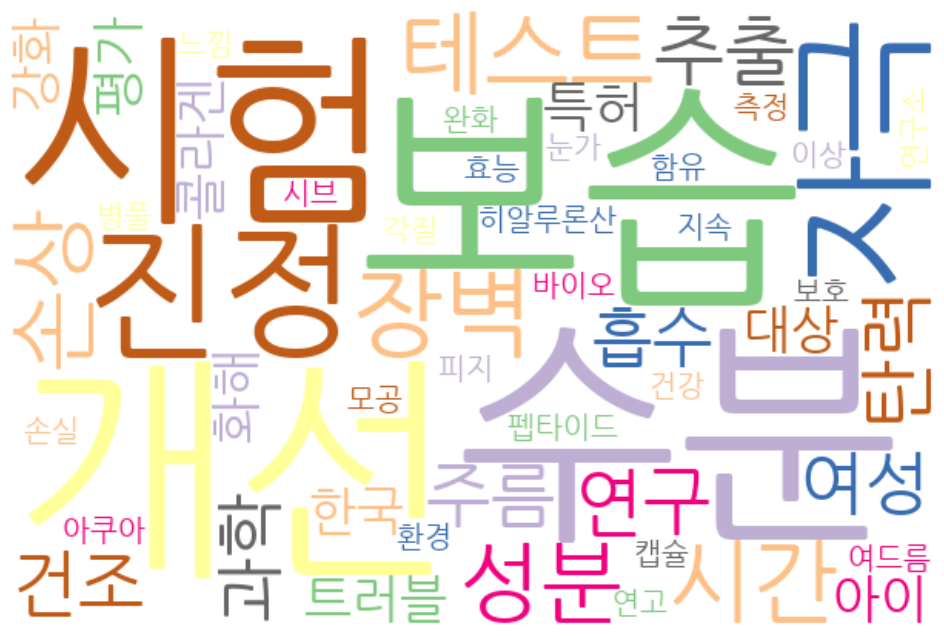

In [91]:
# oliveyoung_top.csv 파일을 읽어 데이터프레임 생성
df = pd.read_csv('oliveyoung_top.csv')

# keyword 컬럼에서 모든 단어를 추출하여 리스트로 변환
keywords = df['Unnamed: 0'].tolist()

# 키워드에서 대괄호와 공백 제거 후, 쉼표로 분리하여 단어 리스트 생성
all_keywords = []
for keyword in keywords:
    cleaned_keyword = re.sub(r'[\[\]\s]', '', keyword)
    all_keywords.extend(cleaned_keyword.split(','))

# 단어 빈도 계산
word_freq = Counter(all_keywords)

# 파일 경로와 워드클라우드 생성
wordcloud = WordCloud(
    font_path=f'NanumGothic.ttf',
    background_color='white',
    colormap='Accent',
    width=600,
    height=400
).generate_from_frequencies(word_freq)

# 워드클라우드 시각화
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') # 눈금 제거
plt.show()

# 제품에 포함되는 키워드들 분류하기

In [92]:
# 데이터 불러오기
olive=pd.read_csv("oliveyoung_text.csv")
keyword=pd.read_csv("oliveyoung_top.csv")

In [93]:
key_set=[[] for i in range(len(olive))]

#제품에 키워드가 들어가있는지 확인하기
for i in range(len(olive)):
    for j in keyword['Unnamed: 0']:
        print(j)
        if olive['text'][i].find(j)!=-1:
            print(j)
            key_set[i].append(j)

수분
수분
보습
보습
개선
개선
시험
시험
진정
자극
자극
장벽
장벽
시간
시간
테스트
테스트
성분
성분
손상
손상
추출
탄력
연구
연구
건조
건조
주름
여성
여성
과학
흡수
흡수
특허
특허
평가
트러블
한국
콜라겐
아이
대상
대상
화해
화해
강화
강화
히알루론산
펩타이드
건강
건강
피지
아쿠아
눈가
지속
지속
손실
환경
환경
각질
각질
여드름
여드름
바이오
연고
측정
완화
캡슐
캡슐
이상
병풀
느낌
느낌
효능
효능
연구소
시브
함유
보호
보호
모공
수분
수분
보습
개선
시험
진정
진정
자극
장벽
시간
테스트
성분
손상
추출
탄력
연구
건조
주름
여성
과학
흡수
특허
평가
트러블
한국
콜라겐
아이
대상
화해
강화
히알루론산
펩타이드
건강
피지
아쿠아
눈가
지속
손실
환경
각질
여드름
바이오
연고
측정
완화
캡슐
이상
병풀
느낌
효능
연구소
시브
함유
보호
모공
수분
수분
보습
개선
개선
시험
진정
자극
자극
장벽
장벽
시간
시간
테스트
테스트
성분
성분
손상
손상
추출
탄력
연구
연구
건조
건조
주름
여성
여성
과학
과학
흡수
흡수
특허
평가
평가
트러블
한국
한국
콜라겐
아이
대상
대상
화해
강화
강화
히알루론산
펩타이드
건강
피지
아쿠아
눈가
지속
손실
손실
환경
각질
각질
여드름
바이오
바이오
연고
측정
측정
완화
캡슐
이상
이상
병풀
느낌
효능
연구소
시브
함유
보호
모공
수분
수분
보습
보습
개선
개선
시험
시험
진정
진정
자극
자극
장벽
시간
시간
테스트
테스트
성분
성분
손상
추출
추출
탄력
탄력
연구
연구
건조
건조
주름
주름
여성
과학
과학
흡수
흡수
특허
특허
평가
평가
트러블
한국
콜라겐
콜라겐
아이
아이
대상
대상
화해
화해
강화
히알루론산
히알루론산
펩타이드
펩타이드
건강
건강
피지
피지
아쿠아
아쿠아
눈가
눈가
지속
손실
손실
환경
각질
여드름
여드름
바이오
바이오
연고
측정
완화
캡슐
이상
이상
병풀
느낌
느낌
효능
연구소
시브
함유
함유
보호
모공
모공
수분
보습
개선
시험
진정
자극
장벽
시간
테스트
성분
손상
추출
탄력
연구
건

In [94]:
# 데이터 저장
raw_data = pd.DataFrame()
raw_data['keyword'] = key_set
raw_data.to_csv("oliveyoung_제품별_키워드.csv")

# 가격 점수 계산

C:\Users\pyk71\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\pyk71\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


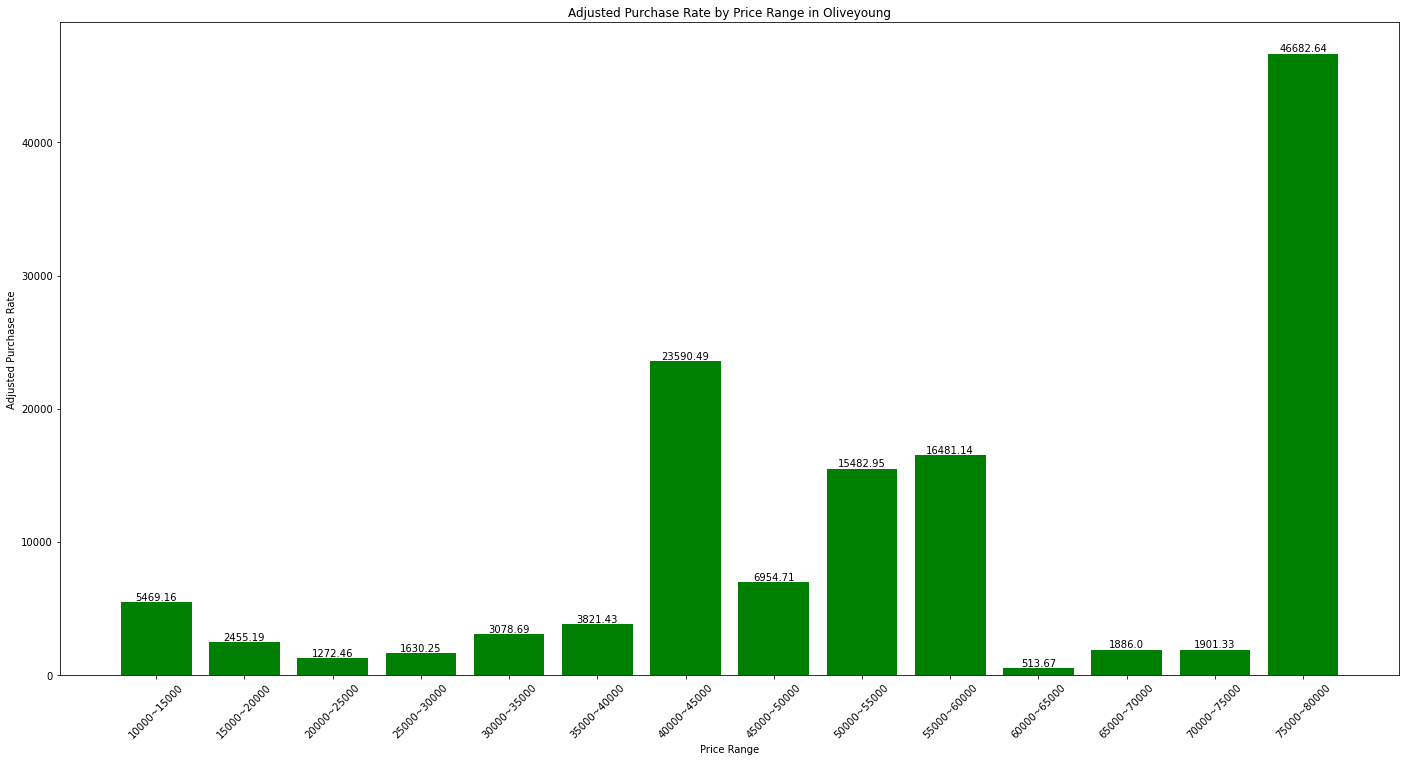

,price_range,total_reviews,product_count,purchase_rate,additional_score,adjusted_purchase_rate
0,10000~15000,14307,19,753.000000,7.263158,5469.157895
1,15000~20000,134662,87,1547.839080,1.586207,2455.193024
2,20000~25000,119833,114,1051.166667,1.210526,1272.464912
3,25000~30000,224974,138,1630.246377,1.000000,1630.246377
4,30000~35000,132272,77,1717.818182,1.792208,3078.687131
5,35000~40000,139593,71,1966.098592,1.943662,3821.431065
6,40000~45000,75387,21,3589.857143,6.571429,23590.489796
7,45000~50000,48431,31,1562.290323,4.451613,6954.711759
8,50000~55000,18961,13,1458.538462,10.615385,15482.946746
9,55000~60000,5852,7,836.000000,19.714286,16481.142857


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

price_ranges = [ # 범위별 가격
    '10000~15000', '15000~20000', '20000~25000',
    '25000~30000', '30000~35000', '35000~40000', '40000~45000', '45000~50000',
    '50000~55000', '55000~60000', '60000~65000', '65000~70000', '70000~75000',
    '75000~80000'
]

total_reviews = [ # 총 리뷰 개수
    14307,134662,119833,224974,132272,139593,75387,48431,18961,5852,134,123,124,8457
]

product_counts = [ # 상품 개수
    19,87,114,138,77,71,21,31,13,7,6,3,3,5
]

# Creating a DataFrame
data = pd.DataFrame({
    'price_range': price_ranges,
    'total_reviews': total_reviews,
    'product_count': product_counts
})

# 구매율
data['purchase_rate'] = data['total_reviews'] / data['product_count'].replace(0, np.nan)

# 추가 점수
max_product_count = data['product_count'].max()
data['additional_score'] = max_product_count / data['product_count'].replace(0, np.nan)

# 조정된 구매율
data['adjusted_purchase_rate'] = data['purchase_rate'] * data['additional_score']

# 시각화

# NaN 값을 0으로 대체하여 시각화에 사용
data = data.fillna(0)

# 시각화
plt.figure(figsize=(24, 12))
bars = plt.bar(data['price_range'], data['adjusted_purchase_rate'], color='green')
plt.xlabel('Price Range')
plt.ylabel('Adjusted Purchase Rate')
plt.title('Adjusted Purchase Rate by Price Range in Oliveyoung')
plt.xticks(rotation=45)

# 각 막대 위에 값 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10)


plt.show()

data.to_csv('oliveyoung_score.csv')
data

# 리뷰개수 * 가격 점수 -> 키워드에 점수 추가

In [96]:
df = pd.read_csv('oliveyoung_keyword_review_cnt_price.csv')

# price_range를 분할하여 최소값과 최대값을 구합니다.
data[['min_price', 'max_price']] = data['price_range'].str.split('~', expand=True).astype(int)

# 각 가격에 맞는 adjusted_purchase_rate를 찾아주는 함수
def find_adjusted_purchase_rate(price):
    row = data[(data['min_price'] <= price) & (data['max_price'] > price)]
    if not row.empty:
        return row.iloc[0]['adjusted_purchase_rate']
    return None


In [97]:
# df에 adjusted_purchase_rate 열 추가
df['adjusted_purchase_rate'] = df['price'].apply(find_adjusted_purchase_rate)

# review_cnt와 adjusted_purchase_rate를 이용하여 new_score를 계산하고, 0.000001로 스케일링
df['new_score'] = df['review_cnt'] * df['adjusted_purchase_rate'] * 0.000001
df

,Unnamed: 0,title,price,review_cnt,keyword,adjusted_purchase_rate,new_score
0,0,에스트라 아토베리어365 크림 80ml 기획 (+하이드로에센스 25ml+리제덤세럼 ...,29700,5467,"['수분', '보습', '개선', '시험', '장벽', '자극', '테스트', '성...",1630.246377,8.912557
1,1,[2세대 천만크림] 닥터지 레드 블레미쉬 클리어 수딩 크림 70ml+30ml 세트,28800,21356,"['수분', '진정']",1630.246377,34.815542
2,2,라로슈포제 시카플라스트 밤B5+ 100ml 기획 (+시카크림 15ml 증정),31200,3400,"['수분', '개선', '장벽', '자극', '테스트', '성분', '손상', '연...",3078.687131,10.467536
3,3,[후니언 PICK] 에스네이처 아쿠아 스쿠알란 수분크림 60ml 기획 (60ml+3...,17900,12753,"['수분', '보습', '개선', '시험', '진정', '자극', '테스트', '성...",2455.193024,31.311077
4,4,[화잘먹크림] 브링그린 티트리시카수딩크림플러스 100mL+100ml 더블기획,20800,5922,['트러블'],1272.464912,7.535537
...,...,...,...,...,...,...,...
100,100,[1+1/아이크림1등] 유세린 하이알루론 3X 아이크림 더블기획 (15ml+15ml),75900,3661,['탄력'],46682.640000,170.905145
101,101,코스알엑스 더 레티놀 0.1 크림 20ml 기획 (+펩타이드세럼 30ml),18700,2175,"['개선', '주름']",2455.193024,5.340045
102,102,[인보라PICK] 센텔리안24 마데카 크림 타임 리버스 단독 기획(15ml*2개+마...,21900,2262,"['탄력', '연구', '여성', '과학', '대상', '연구소', '효능', '모공']",1272.464912,2.878316
103,103,"[단독기획] 아이소이 속보습, 100시간 장수진 수분크림 70ml+15ml 기획",36000,4458,"['보습', '개선', '시험', '자극', '테스트', '성분', '추출', '탄...",3821.431065,17.035940


In [98]:
import re

# 대괄호 제거 및 키워드 추출
df['keyword'] = df['keyword'].apply(lambda x: re.sub(r'[\[\]]', '', x))

# 빈 딕셔너리를 사용하여 keyword별 점수를 저장
keyword_scores = {}

# 각 행을 반복하면서 keyword별 점수를 더함
for _, row in df.iterrows():
    keywords = row['keyword'].split(',')
    score = row['new_score']
    for keyword in keywords:
        if keyword in keyword_scores:
            keyword_scores[keyword] += score
        else:
            keyword_scores[keyword] = score

keyword_scores 

{"'수분'": 1629.5117749438932,
 " '보습'": 1138.3559500645717,
 " '개선'": 1934.2896938150723,
 " '시험'": 1227.2401811521495,
 " '장벽'": 1490.8978658330223,
 " '자극'": 2025.40766312589,
 " '테스트'": 1444.695359175005,
 " '성분'": 2005.4320667202915,
 " '손상'": 1191.074209176556,
 " '연구'": 1523.1247245367858,
 " '건조'": 1855.5903197238051,
 " '여성'": 1435.8172701697233,
 " '흡수'": 1241.0662516513823,
 " '특허'": 411.9123274761687,
 " '대상'": 2093.1766596647763,
 " '화해'": 530.4191204275319,
 " '강화'": 1753.412554088774,
 " '건강'": 1140.4845289678758,
 " '지속'": 950.7443578520788,
 " '환경'": 740.0182854854422,
 " '각질'": 989.6736952470883,
 " '여드름'": 807.2076525680957,
 " '캡슐'": 89.69709960318106,
 " '느낌'": 1098.942578883036,
 " '효능'": 1027.366054097335,
 " '보호'": 422.10666194921475,
 " '안전'": 271.7794505188966,
 " '진정'": 1787.6162975597617,
 " '과학'": 1268.2571418692785,
 " '평가'": 1663.1816432287872,
 " '한국'": 705.8727619230007,
 " '손실'": 942.8235782060583,
 " '바이오'": 1493.1848251665474,
 " '측정'": 707.68088547676

In [10]:
## 동일한 키워드이나 인식이 안된 부분을 수동으로 수정해줌.
# 인덱스가 46인 행 삭제
#keyword_df = keyword_df.drop(index=46)

# 인덱스가 41인 행의 'score' 값을 34676.571051으로 변경
#keyword_df.loc[41, 'score'] =34676.571051

keyword_df = pd.read_csv('clean_keyword_df.csv') # 수동으로 수정한 부분의 df
keyword_df = keyword_df.rename(columns={'title': 'keyword'}) # title행을 keyword로 이름 변경
keyword_df

,Unnamed: 0,keyword,score
0,0,'보습',2106.492703
1,1,'개선',2026.687697
2,2,'성분',2020.374371
3,3,'진정',1932.171102
4,4,'건조',1855.590320
5,5,'강화',1753.412554
6,6,'평가',1663.181643
7,7,'수분',1629.511775
8,8,'바이오',1604.738289
9,9,'연구',1523.124725


# (리뷰별 별점 * 감성분석 점수) 제품마다 총합 -> 해당 키워드에 더해줌

In [2]:
sentiword = pd.read_csv('sentiword_oliveyoung_review.csv')

sentiword['star_senti'] = sentiword['star'] * sentiword['score']

In [3]:
# title이 같은 값마다 star_senti 값을 합산
sentiword_aggregated = sentiword.groupby('title', as_index=False)['star_senti'].sum()

sentiword_aggregated

,title,star_senti
0,11기획센텔리안24 마데카 크림 타임 리버스 50ml 더블 기획15ml2,4907.356746
1,11티트리 세라마이드 아이소이 장수진 수분크림 50ml 11 한정기획50ml50ml,3059.514476
2,1위크림120ml 대용량닥터지 레드블레미쉬 클리어 수딩크림 70ml50ml 한정기획,4503.731161
3,2세대 천만크림 닥터지 레드 블레미쉬 클리어 수딩 크림 70ml30ml 세트,7004.456241
4,3중수분충전 아비브 수분초 히알루론 크림 하이드레이팅 팟 80ml 11 기획,4468.317100
...,...,...
97,후니언 PICK 에스네이처 아쿠아 스쿠알란 수분크림 60ml,3873.749528
98,후니언 PICK 에스네이처 아쿠아 스쿠알란 수분크림 60ml 기획 60ml30ml,4314.157143
99,후니언 PICK11 에스네이처 아쿠아 스쿠알란 수분크림 60ml 더블 기획 카밍패드 2매,4614.835181
100,후니언PICK11 에스네이처 아쿠아 스쿠알란 수분크림 60ml 더블 어워즈 한정기획...,3898.697403


In [4]:
merged_df = pd.merge(df, sentiword_aggregated, on='title', how='inner')
merged_df

NameError: name 'df' is not defined

In [121]:
# keyword를 ,로 분리하고 star_senti를 더하는 함수 정의
def split_keywords_and_sum_senti(df):
    # 빈 리스트를 사용하여 새로운 데이터프레임 생성
    new_data = {'keyword': [], 'star_senti': []}
    
    for index, row in df.iterrows():
        keywords = row['keyword'].split(',')
        star_senti = row['star_senti']
        
        for keyword in keywords:
            if keyword in new_data['keyword']:
                new_data['star_senti'][new_data['keyword'].index(keyword)] += star_senti
            else:
                new_data['keyword'].append(keyword)
                new_data['star_senti'].append(star_senti)
    
    return pd.DataFrame(new_data)

# 함수 적용
result_df = split_keywords_and_sum_senti(merged_df)
result_df

,keyword,star_senti
0,'보습',17372.285029
1,'시험',54605.821066
2,'자극',58939.555986
3,'성분',58939.555986
4,'추출',39524.291775
5,'연구',54268.245669
6,'여성',49666.746390
7,'과학',42991.703932
8,'평가',45787.703605
9,'흡수',54268.245669


In [122]:
## 동일한 키워드이나 인식이 안된 부분을 수동으로 수정해줌.
# 인덱스가 46인 행 삭제
#result_df = result_df.drop(index=46)

# 인덱스가 41인 행의 'star_senti' 값을 34676.571051으로 변경
#result_df.loc[41, 'star_senti'] =34676.571051

result_df = pd.read_csv('real_result_df.csv')
result_df

,Unnamed: 0,keyword,star_senti
0,0,'보습',59038.908079
1,1,'시험',54605.821066
2,2,'자극',58939.555986
3,3,'성분',62326.341700
4,4,'추출',39524.291775
5,5,'연구',54268.245669
6,6,'여성',49666.746390
7,7,'과학',42991.703932
8,8,'평가',45787.703605
9,9,'흡수',54268.245669


In [123]:
keyword_df

,Unnamed: 0,keyword,score
0,0,'보습',2106.492703
1,1,'개선',2026.687697
2,2,'성분',2020.374371
3,3,'진정',1932.171102
4,4,'건조',1855.590320
5,5,'강화',1753.412554
6,6,'평가',1663.181643
7,7,'수분',1629.511775
8,8,'바이오',1604.738289
9,9,'연구',1523.124725


In [124]:
# 두 데이터프레임을 keyword를 기준으로 병합
merged_df = pd.merge(keyword_df, result_df, on='keyword', how='outer')

# 같은 keyword에 대한 star_senti 값 합산
merged_df['star_senti'] = merged_df['star_senti'].fillna(0)
final_df = merged_df.groupby('keyword', as_index=False).sum()

final_df = final_df[["keyword", "score", "star_senti"]]
final_df

,keyword,score,star_senti
0,'각질',989.673695,23649.132105
1,'강화',1753.412554,24113.918973
2,'개선',2026.687697,50478.002415
3,'건강',1140.484529,43358.672944
4,'건조',1855.590320,38157.390979
5,'과학',1268.257142,42991.703932
6,'눈가',255.311299,16581.825361
7,'모공',721.245567,0.000000
8,'바이오',1604.738289,25365.860281
9,'병풀',206.335714,20881.517100


In [125]:
# final_df 전처리
# 키워드 중에 동일한데 점수 계산이 합산이 안된 부분 
final_df = pd.read_csv('final_score_merged_df.csv')

In [126]:
# score와 star_senti 열의 값을 합산하여 final_score 열을 생성
final_df['final_score'] = final_df["score"] + final_df["star_senti"] 

# final_score 열을 기준으로 내림차순으로 정렬하고 인덱스를 무시
final_df.sort_values(by='final_score', ascending=False, ignore_index=True)


,Unnamed: 0,keyword,score,star_senti,final_score
0,1,'성분',2020.374371,62326.341700,64346.716071
1,46,보습,2106.492703,59038.908080,61145.400783
2,19,'자극',1146.404219,58939.555986,60085.960205
3,16,'시험',1227.240181,54605.821066,55833.061247
4,8,'연구',1523.124725,54268.245669,55791.370393
5,15,'흡수',1241.066252,54268.245669,55509.311921
6,0,'개선',2026.687697,50478.002415,52504.690112
7,12,'여성',1443.508773,49666.746390,51110.255163
8,21,'효능',1027.366054,47131.110606,48158.476660
9,6,'수분',1629.511775,46365.277812,47994.789587


# 리뷰데이터 N-gram

In [127]:
# 라이브러리 불러오기
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk # 자연어 처리를 위한 파이썬 패키지
from nltk.util import ngrams # 문자열에서 N개의 연속된 요소를 추출하는 방법

In [128]:
# 데이터 불러오기
df = pd.read_csv('sentiword_oliveyoung_review.csv')

In [129]:
# 감성 분석 결과를 바탕으로 긍정, 중립, 부정을 나타내는 sentiment 열 추가
senti = []

for i in range(len(df)):
    if df['score'].iloc[i] <= -0.4:
        senti.append(-1)     # -0.4 이하인 경우 부정적으로 판단, -1로 표시
    elif df['score'].iloc[i] <= 0.4:
        senti.append(0)      # -0.4 초과 0.4 이하인 경우 중립적으로 판단, 0으로 표시
    else:
        senti.append(1)      # 0.4 초과인 경우 긍정적으로 판단, 1로 표시
    
df['sentiment'] = senti
df

,title,star,review,sentiword,values,score,sentiment
0,에스트라 아토베리어365 크림 80ml 기획 하이드로에센스 25ml리제덤세럼 7ml,5,예민한 피부에도 사용할 수 있어서 전신용으로 늘 구비해두고 있어요얼굴보다 몸이 더 ...,"['강추', '따가울', '좋아', '함부로']","[2, -1, 2, -1]",0.500000,1
1,에스트라 아토베리어365 크림 80ml 기획 하이드로에센스 25ml리제덤세럼 7ml,5,장점 다들 아시죠피부과에서도 쓰는 제품 보습력 정말 끝판왕 아기도 발라도 되서 많...,"['세일', '장점', '좋아']","[1, 2, 2]",1.666667,1
2,에스트라 아토베리어365 크림 80ml 기획 하이드로에센스 25ml리제덤세럼 7ml,5,살지말지 고민많이하다가 샀는데 너무너무 만족하고 잘 쓰고 있어요 또 살거에요,['만족'],[2],2.000000,1
3,에스트라 아토베리어365 크림 80ml 기획 하이드로에센스 25ml리제덤세럼 7ml,5,화장전 수분 크림용으로 구매 했어요 ㅋ만족합니다 세일 자주 했으면 좋겠어요,"['만족', '세일']","[2, 1]",1.500000,1
4,에스트라 아토베리어365 크림 80ml 기획 하이드로에센스 25ml리제덤세럼 7ml,5,촉촉하고 위에 보습막 올라와서 수분유지에도 좋아요 ㅎㅎ 순하고 보습감 좋은 편안한...,"['좋아', '좋은', '편안', '편안한', 'ㅎㅎ']","[2, 2, 2, 2, 1]",1.800000,1
...,...,...,...,...,...,...,...
109235,피지오겔 레드수딩 시카밸런스 크림 80ml 기획,5,이제품 사용한지 1년지났는데 넘좋아요 가격할인에 샘플도 받았네요,"['용한', '좋아', '할인']","[1, 2, 1]",1.333333,1
109236,피지오겔 레드수딩 시카밸런스 크림 80ml 기획,4,라로슈포제 제품은 10년전에도 워낙 유명한 제품으로 알고있었는데 최근에 필링한 이...,"['꾸준히', '유명한', '좋을', 'ㅎㅎ']","[2, 1, 2, 1]",1.500000,1
109237,피지오겔 레드수딩 시카밸런스 크림 80ml 기획,5,흠 유튜브에서 보고 산건데재생크림으로 좋다규하길래 mts 후 바르려고 산건데요움 ...,['좋다'],[2],2.000000,1
109238,피지오겔 레드수딩 시카밸런스 크림 80ml 기획,5,자극 없이 순하고 밤에 자기전에 바르고 자면 다음날 아침피부 좋아요,"['바르고', '좋아']","[2, 2]",2.000000,1


In [130]:
# Unigram 추출 함수 정의
def extract_ngrams(tokens, num):
    # ngrams() 함수를 사용하여 입력 토큰(tokens)에서 길이가 num인 n-그램을 추출
    n_grams = ngrams(tokens, num)
    n_grams = [ ' '.join(grams) for grams in n_grams] # 추출된 n-그램을 공백으로 구분된 문자열로 변환
    return n_grams # 변환된 n-그램 리스트를 반환

# Unigram 카운트 함수 정의
def count_ngrams(df, num):
    # 빈 딕셔너리를 생성하여 n-그램과 해당 빈도를 저장할 gram_dict 변수를 초기화
    gram_dict = {}
    for i in df:
        # extract_ngrams 함수를 사용하여 현재 항목 i에서 길이가 num인 n-그램을 추출
        grams = extract_ngrams(i, num)
        
        # 추출된 n-그램들을 반복하여 gram_dict에 추가하거나 갱신
        for j in grams:
            if j in gram_dict:
                gram_dict[j] += 1
            else:
                gram_dict[j] = 1
                
    # gram_dict의 항목들을 빈도를 기준으로 내림차순으로 정렬하여 새로운 딕셔너리로 변환
    gram_dict = dict(sorted(gram_dict.items(), key=lambda item: item[1], reverse=True))
    return gram_dict

## 1개 단어

In [ ]:
# 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

In [148]:
import pandas as pd
from tqdm import tqdm # 반복문 진행 상황을 표시
from konlpy.tag import Komoran # 한국어 형태소 분석을 위한 Komoran 클래스

komoran = Komoran() # Komoran 클래스의 인스턴스 생성

doc_token_list = [] # 본문의 형태소를 담아낼 리스트
doc_token_noun = [] # 본문의 명사를 담아낼 리스트

for i in tqdm(range(len(df))):
    try:
        # komoran.pos() 메서드를 사용하여 형태소 분석 결과
        pos = komoran.pos(u'{}'.format(df['review'][i]))
        
        # komoran.nouns() 메서드를 사용하여 명사만 추출, 길이가 2 이상인 명사만 리스트에 저장
        noun = list(term for term in komoran.nouns(u'{}'.format(df['review'][i])) if len(term) > 1)
        
        doc_token_list.append(pos) # 형태소 분석결과를 리스트에 추가
        doc_token_noun.append(noun) # 추출한 명사를 리스트에 추가
        
    except Exception as e:
        print(f"Error processing review at index {i}: {e}")
        doc_token_list.append([]) # 에러가 발생한 경우 빈 리스트 추가
        doc_token_noun.append([]) # 에러가 발생한 경우 빈 리스트 추가

# 새로운 열을 DataFrame에 추가
df['doc_token_list'] = doc_token_list
df['doc_token_noun'] = doc_token_noun

print(df)

  0%|▏                                    | 396/109240 [00:02<05:59, 303.17it/s]

Error processing review at index 173: java.lang.NullPointerException
Error processing review at index 174: java.lang.NullPointerException
Error processing review at index 175: java.lang.NullPointerException
Error processing review at index 176: java.lang.NullPointerException
Error processing review at index 177: java.lang.NullPointerException
Error processing review at index 178: java.lang.NullPointerException
Error processing review at index 179: java.lang.NullPointerException
Error processing review at index 180: java.lang.NullPointerException
Error processing review at index 181: java.lang.NullPointerException
Error processing review at index 182: java.lang.NullPointerException
Error processing review at index 183: java.lang.NullPointerException
Error processing review at index 184: java.lang.NullPointerException
Error processing review at index 185: java.lang.NullPointerException
Error processing review at index 186: java.lang.NullPointerException
Error processing review at index 1

  1%|▏                                    | 685/109240 [00:02<02:56, 614.52it/s]

Error processing review at index 476: java.lang.NullPointerException
Error processing review at index 477: java.lang.NullPointerException
Error processing review at index 478: java.lang.NullPointerException
Error processing review at index 479: java.lang.NullPointerException
Error processing review at index 480: java.lang.NullPointerException
Error processing review at index 481: java.lang.NullPointerException
Error processing review at index 482: java.lang.NullPointerException
Error processing review at index 483: java.lang.NullPointerException
Error processing review at index 484: java.lang.NullPointerException
Error processing review at index 485: java.lang.NullPointerException
Error processing review at index 486: java.lang.NullPointerException
Error processing review at index 487: java.lang.NullPointerException
Error processing review at index 488: java.lang.NullPointerException
Error processing review at index 489: java.lang.NullPointerException
Error processing review at index 4

  1%|▎                                    | 988/109240 [00:02<01:55, 933.89it/s]

Error processing review at index 770: java.lang.NullPointerException
Error processing review at index 771: java.lang.NullPointerException
Error processing review at index 772: java.lang.NullPointerException
Error processing review at index 773: java.lang.NullPointerException
Error processing review at index 774: java.lang.NullPointerException
Error processing review at index 775: java.lang.NullPointerException
Error processing review at index 776: java.lang.NullPointerException
Error processing review at index 777: java.lang.NullPointerException
Error processing review at index 778: java.lang.NullPointerException
Error processing review at index 779: java.lang.NullPointerException
Error processing review at index 780: java.lang.NullPointerException
Error processing review at index 781: java.lang.NullPointerException
Error processing review at index 782: java.lang.NullPointerException
Error processing review at index 783: java.lang.NullPointerException
Error processing review at index 7

  1%|▍                                  | 1295/109240 [00:02<01:30, 1186.37it/s]

Error processing review at index 1076: java.lang.NullPointerException
Error processing review at index 1077: java.lang.NullPointerException
Error processing review at index 1078: java.lang.NullPointerException
Error processing review at index 1079: java.lang.NullPointerException
Error processing review at index 1080: java.lang.NullPointerException
Error processing review at index 1081: java.lang.NullPointerException
Error processing review at index 1082: java.lang.NullPointerException
Error processing review at index 1083: java.lang.NullPointerException
Error processing review at index 1084: java.lang.NullPointerException
Error processing review at index 1085: java.lang.NullPointerException
Error processing review at index 1086: java.lang.NullPointerException
Error processing review at index 1087: java.lang.NullPointerException
Error processing review at index 1088: java.lang.NullPointerException
Error processing review at index 1089: java.lang.NullPointerException
Error processing rev

  4%|█▎                                  | 3888/109240 [00:05<01:45, 993.94it/s]

Error processing review at index 3701: java.lang.NullPointerException
Error processing review at index 3702: java.lang.NullPointerException
Error processing review at index 3703: java.lang.NullPointerException


 11%|███▊                               | 11821/109240 [00:14<01:39, 976.72it/s]

Error processing review at index 11604: java.lang.NullPointerException
Error processing review at index 11605: java.lang.NullPointerException
Error processing review at index 11606: java.lang.NullPointerException
Error processing review at index 11607: java.lang.NullPointerException
Error processing review at index 11608: java.lang.NullPointerException
Error processing review at index 11609: java.lang.NullPointerException
Error processing review at index 11610: java.lang.NullPointerException
Error processing review at index 11611: java.lang.NullPointerException
Error processing review at index 11612: java.lang.NullPointerException
Error processing review at index 11613: java.lang.NullPointerException
Error processing review at index 11614: java.lang.NullPointerException
Error processing review at index 11615: java.lang.NullPointerException
Error processing review at index 11616: java.lang.NullPointerException
Error processing review at index 11617: java.lang.NullPointerException
Error 

 11%|███▊                              | 12092/109240 [00:15<01:30, 1069.22it/s]

Error processing review at index 11901: java.lang.NullPointerException
Error processing review at index 11902: java.lang.NullPointerException
Error processing review at index 11903: java.lang.NullPointerException
Error processing review at index 11904: java.lang.NullPointerException
Error processing review at index 11905: java.lang.NullPointerException
Error processing review at index 11906: java.lang.NullPointerException
Error processing review at index 11907: java.lang.NullPointerException
Error processing review at index 11908: java.lang.NullPointerException
Error processing review at index 11909: java.lang.NullPointerException
Error processing review at index 11910: java.lang.NullPointerException
Error processing review at index 11911: java.lang.NullPointerException
Error processing review at index 11912: java.lang.NullPointerException
Error processing review at index 11913: java.lang.NullPointerException
Error processing review at index 11914: java.lang.NullPointerException
Error 

 18%|█████▉                            | 19250/109240 [00:23<01:10, 1277.90it/s]

Error processing review at index 19287: java.lang.NullPointerException


 22%|███████▌                          | 24130/109240 [00:29<01:17, 1096.36it/s]

Error processing review at index 24005: java.lang.NullPointerException


 27%|█████████                         | 29002/109240 [00:35<01:05, 1218.94it/s]

Error processing review at index 29076: java.lang.NullPointerException


 27%|█████████▏                        | 29584/109240 [00:35<01:12, 1091.76it/s]

Error processing review at index 29306: java.lang.NullPointerException


 27%|█████████▎                        | 29849/109240 [00:36<01:09, 1144.34it/s]

Error processing review at index 29937: java.lang.NullPointerException


 33%|███████████▍                       | 35687/109240 [00:42<01:27, 840.07it/s]

Error processing review at index 35576: java.lang.NullPointerException


KeyboardInterrupt: 

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/var/folders/01/3d4wx8r1

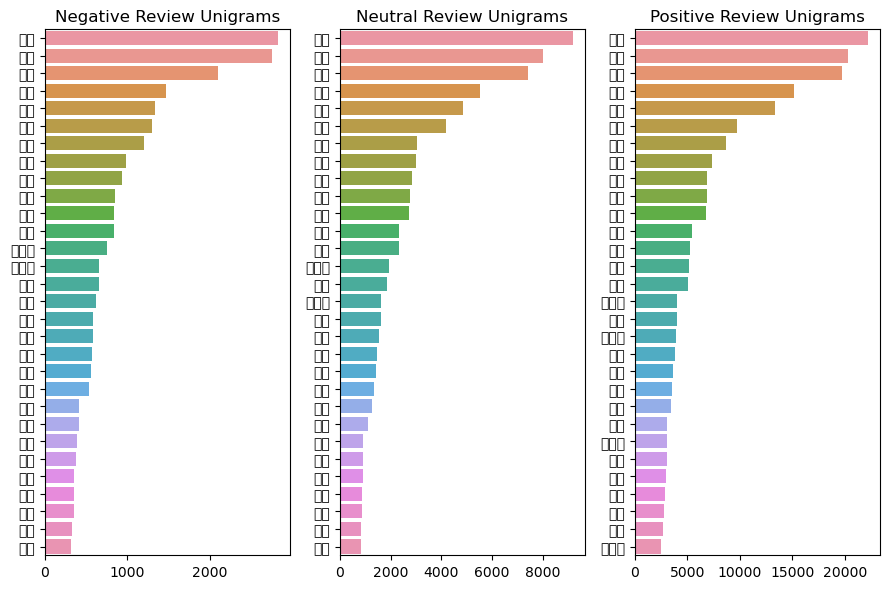

In [146]:
# 부정, 중립, 긍정 리뷰에 대한 Unigram 추출 및 시각화
unigrams_neg = count_ngrams(df[df['sentiment']==-1]['doc_token_noun'], 1)
unigrams_neu = count_ngrams(df[df['sentiment']==0]['doc_token_noun'], 1)
unigrams_pos = count_ngrams(df[df['sentiment']==1]['doc_token_noun'], 1)

# 1x3 그리드의 서브플롯 생성
fig, axes = plt.subplots(1, 3, figsize=(9,6))
num = 30   # 상위 30개의 Unigram만 시각화
sns.barplot(x=list(unigrams_neg.values())[:num], y=list(unigrams_neg.keys())[:num], ax=axes[0])
sns.barplot(x=list(unigrams_neu.values())[:num], y=list(unigrams_neu.keys())[:num], ax=axes[1])
sns.barplot(x=list(unigrams_pos.values())[:num], y=list(unigrams_pos.keys())[:num], ax=axes[2])

# 서브플롯 타이틀 설정
axes[0].set_title('Negative Review Unigrams')
axes[1].set_title('Neutral Review Unigrams')
axes[2].set_title('Positive Review Unigrams')

# 서브플롯 간 간격 조절
plt.tight_layout()
plt.show()

## 2개 단어

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/var/folders/0

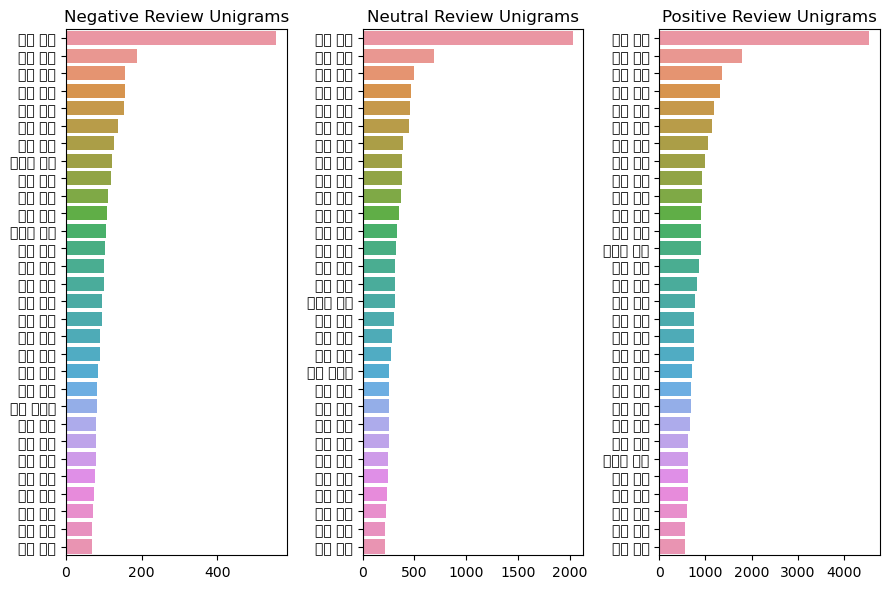

In [134]:
# 부정, 중립, 긍정 리뷰에 대한 Bigram 추출 및 시각화
unigrams_neg = count_ngrams(df[df['sentiment']==-1]['doc_token_noun'], 2)
unigrams_neu = count_ngrams(df[df['sentiment']==0]['doc_token_noun'], 2)
unigrams_pos = count_ngrams(df[df['sentiment']==1]['doc_token_noun'], 2)

# 1x3 그리드의 서브플롯 생성
fig, axes = plt.subplots(1, 3, figsize=(9,6))
num = 30   # 상위 30개의 Bigram만 시각화
sns.barplot(x=list(unigrams_neg.values())[:num], y=list(unigrams_neg.keys())[:num], ax=axes[0])
sns.barplot(x=list(unigrams_neu.values())[:num], y=list(unigrams_neu.keys())[:num], ax=axes[1])
sns.barplot(x=list(unigrams_pos.values())[:num], y=list(unigrams_pos.keys())[:num], ax=axes[2])

# 서브플롯 타이틀 설정
axes[0].set_title('Negative Review Unigrams')
axes[1].set_title('Neutral Review Unigrams')
axes[2].set_title('Positive Review Unigrams')

# 서브플롯 간 간격 조절
plt.tight_layout()
plt.show()

## 3개 단어

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/var/folders/0

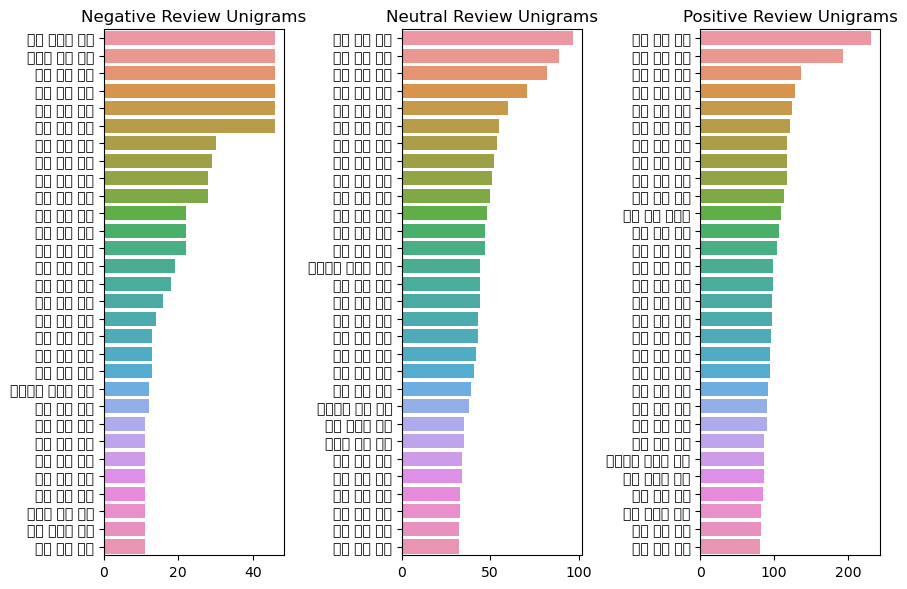

In [135]:
# 부정, 중립, 긍정 리뷰에 대한 Bigram 추출 및 시각화
unigrams_neg = count_ngrams(df[df['sentiment']==-1]['doc_token_noun'], 3)
unigrams_neu = count_ngrams(df[df['sentiment']==0]['doc_token_noun'], 3)
unigrams_pos = count_ngrams(df[df['sentiment']==1]['doc_token_noun'], 3)

# 1x3 그리드의 서브플롯 생성
fig, axes = plt.subplots(1, 3, figsize=(9,6))
num = 30   # 상위 30개의 Bigram만 시각화
sns.barplot(x=list(unigrams_neg.values())[:num], y=list(unigrams_neg.keys())[:num], ax=axes[0])
sns.barplot(x=list(unigrams_neu.values())[:num], y=list(unigrams_neu.keys())[:num], ax=axes[1])
sns.barplot(x=list(unigrams_pos.values())[:num], y=list(unigrams_pos.keys())[:num], ax=axes[2])

# 서브플롯 타이틀 설정
axes[0].set_title('Negative Review Unigrams')
axes[1].set_title('Neutral Review Unigrams')
axes[2].set_title('Positive Review Unigrams')

# 서브플롯 간 간격 조절
plt.tight_layout()
plt.show()

# 시각화

In [149]:
d = pd.read_csv('final_score_merged_df.csv')
d.sort_values(by='final_score', ascending=False, ignore_index=True)

,Unnamed: 0,keyword,score,star_senti,final_score
0,1,'성분',2020.374371,62326.341700,64346.716071
1,46,보습,2106.492703,59038.908080,61145.400783
2,19,'자극',1146.404219,58939.555986,60085.960205
3,16,'시험',1227.240181,54605.821066,55833.061247
4,8,'연구',1523.124725,54268.245669,55791.370393
5,15,'흡수',1241.066252,54268.245669,55509.311921
6,0,'개선',2026.687697,50478.002415,52504.690112
7,12,'여성',1443.508773,49666.746390,51110.255163
8,21,'효능',1027.366054,47131.110606,48158.476660
9,6,'수분',1629.511775,46365.277812,47994.789587


In [150]:
for i in range(len(d['keyword'])):
    d['keyword'][i]=re.sub("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]",'',str(d['keyword'][i]))

/var/folders/01/3d4wx8r11dx2kjml_tq2t48c0000gn/T/ipykernel_61116/3471088947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['keyword'][i]=re.sub("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]",'',str(d['keyword'][i]))
/var/folders/01/3d4wx8r11dx2kjml_tq2t48c0000gn/T/ipykernel_61116/3471088947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['keyword'][i]=re.sub("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]",'',str(d['keyword'][i]))
/var/folders/01/3d4wx8r11dx2kjml_tq2t48c0000gn/T/ipykernel_61116/3471088947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pa

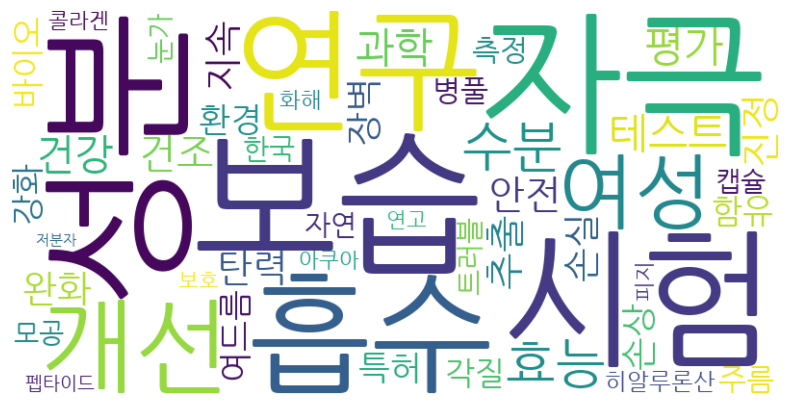

In [151]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 예제 데이터 생성 (단어와 값의 쌍으로 이루어진 딕셔너리)
word_values = d.set_index('keyword')['final_score'].to_dict()

# 워드클라우드 객체 생성
wordcloud = WordCloud(font_path='NanumGothic.ttf',width=800, height=400, background_color='white')

# 값의 크기를 기반으로 워드클라우드 생성
wordcloud.generate_from_frequencies(word_values)

# 워드클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()